In [1]:
import matplotlib.pyplot as plt
import utils
import numerical_hysteresis
import synthetic
import torch
import numpy as np

In [2]:
# Loss function
def l(x, h, m, n, xx, yy, h_sat, b_sat, states):

    m_pred = numerical_hysteresis.discreteIntegral(xx, yy, h_sat, b_sat, x, h, n, states)
    loss = torch.sum((m_pred - m)**2)
    
    return loss

#print(x.shape)
#loss = l(x,h,m,n)
#loss.backward()


In [3]:
# Gradient descent implementation
def gradient_descent(Z0, function, alpha, n_iterations, h, m, n, xx, yy, h_sat, b_sat, states):
    """
    Performs gradient descent
    
    Inputs:
    Z0: a pytorch tensor to be modified in-place by the gradient descent algorithm
    function: a callable, that takes Z0 as input
    alpha: step size for the gradient descent algorithm
    n_iterations: number of iterations of gradient descent
    
    Returns:
    history_Z: array of values of Z
    history_f: array of values of f
    """
    history_Z = []
    history_f = []
    for iteration in range(n_iterations): # iterations of gradient descent
        X0 = torch.nn.Softplus()(Z0)
        f = function(X0, h, m, n, xx, yy, h_sat, b_sat, states)
        f.backward()
        with torch.no_grad():
            Z0 -= alpha * Z0.grad
        
        Z0.grad.zero_()
        
        # Keep a copy in history 
        history_Z.append( Z0.detach().numpy().copy() ) 
        history_f.append( f.detach().numpy().copy() )
        
        # Tracks computational progress
        if iteration % 500 == 0:
            print(f"{iteration} iterations completed")
        
    return np.array(history_Z), np.array(history_f)

In [4]:
def plot_lfunc(loss):
    print(f"Loss function converges to {loss[-1]}")
    fig_lf = plt.figure()
    plt.plot(loss)
    plt.title('Optimization Path')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    
def plot_density(x, n):
    fig_dens = plt.figure()
    mat = utils.vector_to_tril(x, n)
    plt.imshow(mat, origin="lower")
    plt.colorbar()
    
def plot_loops(h, m, m_pred, m_start):
    fig_loops = plt.figure()
    plt.plot(h, m, 'o')
    plt.plot(h, m_pred)
    plt.plot(h, m_start)
    plt.title('Magnetic Hysteresis Loops')
    plt.xlabel('Applied Magnetic Field, $H$')
    plt.ylabel('Resulting Magnetization, $M$')


In [5]:
def optimize(num_points, h, m, h_sat, b_sat, lfunc, alpha, num_iterations):
    x_in = utils.gen_xi(num_points)
    
    xx, yy = utils.generate_mesh(h_sat, num_points)
    states = numerical_hysteresis.state(xx, yy, h_sat, h)
    
    history_Z, history_f = gradient_descent(x_in, lfunc, alpha, num_iterations, h, m, 
                                            num_points, xx, yy, h_sat, b_sat, states)
    
    x_star = torch.nn.Softplus()(torch.tensor(history_Z[-1]).double())    
    x_start = torch.nn.Softplus()(torch.tensor(history_Z[0]).double())
    
    m_pred = numerical_hysteresis.discreteIntegral(xx, yy, h_sat, b_sat, x_star, h, num_points, states)
    m_start = numerical_hysteresis.discreteIntegral(xx, yy, h_sat, b_sat, x_start, h, num_points, states)
    
    # Plot the trajectory of the loss function
    plot_lfunc(history_f)
    
    # Plot optimized hysterion density distribution
    plot_density(x_star, num_points)
    
    # Plot H x M hysteresis loop
    plot_loops(h, m, m_pred, m_start)

0 iterations completed
500 iterations completed
1000 iterations completed
1500 iterations completed
Loss function converges to 0.05957651138305664


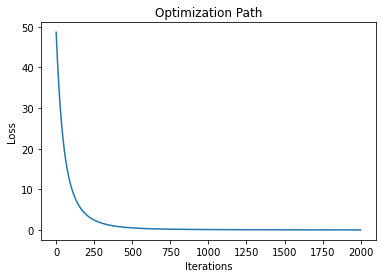

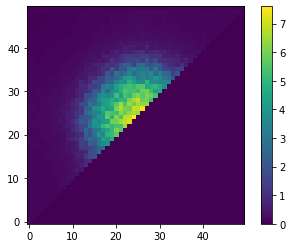

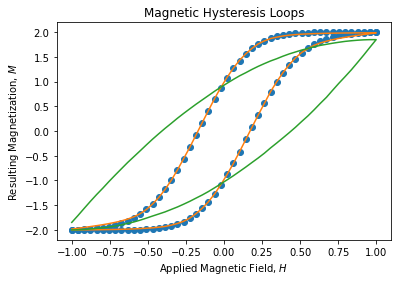

In [6]:
# Implementation
n = 50
h,m = synthetic.generate_dataset(n)
x = torch.rand(int(n**2 / 2 + n / 2)).double()
x.requires_grad=True 

h_sat = 1.0
b_sat = 2.0

xx, yy=utils.generate_mesh(h_sat, n)

states=numerical_hysteresis.state(xx, yy, h_sat, h)

alpha = .50
num_iterations = 2000

optimize(n, h, m, h_sat, b_sat, l, alpha, num_iterations)

In [9]:
# repeatability test

def compute_density(lfunc, alpha, num_iterations, h, m, n, xx, yy, h_sat, b_sat, states):
    '''
    Calculates the optimum density, given a random intial density vector.
    This initial vector, x_test, is randomly generated each time that
    compute_density is called. 
    '''
    x_test = torch.rand(int(n**2 / 2 + n / 2)).double()
    x_test.requires_grad=True 
    history_Z, history_f = gradient_descent(x_test, lfunc, alpha, num_iterations, h, m, 
                                            n, xx, yy, h_sat, b_sat, states)
    x_star = torch.nn.Softplus()(torch.tensor(history_Z[-1]).double())
    return x_star

def run_trials(num_trials, lfunc, alpha, num_iterations, h, m, n, xx, yy, h_sat, b_sat, states):
    trial_matrix = torch.empty(num_trials, (int(n**2 / 2 + n / 2)))
    for i in range(num_trials):
        trial_matrix[i] = compute_density(lfunc, alpha, num_iterations, h, m, n, xx, yy, h_sat, b_sat, states)
        print(f"trial: {i+1}")
    return trial_matrix

mtx = run_trials(15, l, alpha, num_iterations, h, m, n, xx, yy, h_sat, b_sat, states)
np.save("mtx.npy", mtx)

0 iterations completed
500 iterations completed
1000 iterations completed
1500 iterations completed
trial: 0
0 iterations completed
500 iterations completed
1000 iterations completed
1500 iterations completed
trial: 1
0 iterations completed
500 iterations completed
1000 iterations completed
1500 iterations completed
trial: 2
0 iterations completed
500 iterations completed
1000 iterations completed
1500 iterations completed
trial: 3
0 iterations completed
500 iterations completed
1000 iterations completed
1500 iterations completed
trial: 4
0 iterations completed
500 iterations completed
1000 iterations completed


KeyboardInterrupt: 

In [ ]:
def repeatability(trial_matrix, plot_size, num_trials):
    x_avg = trial_matrix.mean(axis=0) 
    x_sd = trial_matrix.std(axis=0)

    # plot density triangles side-by-side
    fig_dens = plt.figure()
    plt.subplot(1, 3, 1)
    plot_density(torch.tensor(x_avg).double(), n)
    fig_dens.set_figheight(plot_size)
    fig_dens.set_figwidth(plot_size)
    plt.title(f"{num_trials} Trial Average Density")

    plt.subplot(1, 3, 2)
    plot_density(torch.tensor(x_sd).double(),n)
    fig_dens.set_figheight(plot_size)
    fig_dens.set_figwidth(plot_size)
    plt.title(f"{num_trials} Trial Standard Deviation")

    plt.subplot(1, 3, 3)
    plot_density((torch.tensor(x_sd/x_avg)).double(), n)
    fig_dens.set_figheight(plot_size)
    fig_dens.set_figwidth(plot_size)
    plt.title("Fractional Uncertainty")

    print(f"Max Standard Deviation: {max(x_sd)}")
    # # scatter plot of standard deviation
    # sd_plot = plt.figure(figsize = (9,9)) 
    # plt.scatter(np.arange(int(n**2 / 2 + n / 2)), x_sd)
    # plt.xlabel('Hysterion Index')
    # plt.ylabel('Standard Deviation Over Trials')
    
mtx = np.load("mtx.npy")
repeatability(mtx, 15, 15)